In [422]:
import numpy as np
import pygame
import time
import noise
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.animation import FuncAnimation
from scipy.signal import convolve2d, fftconvolve
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

In [24]:
def scale_array(array_input, minimum = 0, maximum = 1):
    array_output = array_input.copy()
    array_output -= array_output.min()
    array_output /= array_output.max()
    array_output *= maximum - minimum
    array_output += minimum
    return array_output

def interpolate_images(images_input):
    images_output = np.zeros((images_input.shape[0]*2 - 1, images_input.shape[1], images_input.shape[2]))
    for index, image in enumerate(images_input):
        images_output[index*2] = image
    for index in np.arange(1, images_output.shape[0], 2):
        images_output[index] = images_output[[index - 1, index + 1]].mean(0)
    return images_output

def cellular_automaton(input_array, rule):
    kernel = np.ones((3, 3), dtype = int)
    kernel[1, 1] = 0 # Messing around with the kernel gives some cool patterns.
    convolved_array = convolve2d(input_array.astype(int), kernel, mode = "same", boundary = "wrap")
    return np.where(np.logical_or(np.logical_and(~input_array, np.isin(convolved_array, rule["B"])), np.logical_and(input_array, np.isin(convolved_array, rule["S"]))), True, False)

def voronoi(rng, shape, points = None, number_points = None, wrapped = False, return_points = False):
    if points is None:
        points = np.array([(y, x) for y, x in zip(rng.uniform(0, shape[0], size = number_points), rng.uniform(0, shape[1], size = number_points))])
    if wrapped:
        points_offset = np.concatenate([points + offset for offset in [[y_offset, x_offset] for y_offset in [-shape[0], 0, shape[0]] for x_offset in [-shape[1], 0, shape[1]]]], axis = 0)
    coordinates = np.array(np.meshgrid(np.arange(shape[1]), np.arange(shape[0])))
    if wrapped:
        regions = np.array([np.linalg.norm(coordinates - point[::-1, None, None], axis = 0) for point in points_offset]).argmin(0)%points.shape[0]
    elif not wrapped:
        regions = np.array([np.linalg.norm(coordinates - point[::-1, None, None], axis = 0) for point in points]).argmin(0)
    return (regions, points) if return_points else regions

def rotated_sin(angle = 0, amplitude = 1, frequency = 1, phase = 0, shape = (64, 64), warp = None):
    frequency = np.finfo(float).eps if not frequency else frequency
    warp = np.zeros((2, shape[0], shape[1])) if warp is None else warp
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    coordinates = (np.array(np.meshgrid(np.linspace(0, 2*np.pi, shape[1]), np.linspace(0, 2*np.pi, shape[0]))) + warp).reshape((2, shape[0]*shape[1]))
    translation = coordinates.mean(axis = 1, keepdims = True) + np.expand_dims(np.array((0, 0)), 1)
    coordinates -= translation
    coordinates = rotation_matrix@coordinates
    coordinates += translation
    coordinates = np.sum(coordinates.reshape((2, shape[0], shape[1])), axis = 0)
    return amplitude*np.sin(frequency*(coordinates + phase))

In [19]:
def interpolate_images(images_input):
    images_output = np.empty((images_input.shape[0]*2 - 1, images_input.shape[1], images_input.shape[2]))
    images_output[0::2] = images_input
    images_output[1::2] = (images_input[:-1] + images_input[1:]) / 2
    return images_output

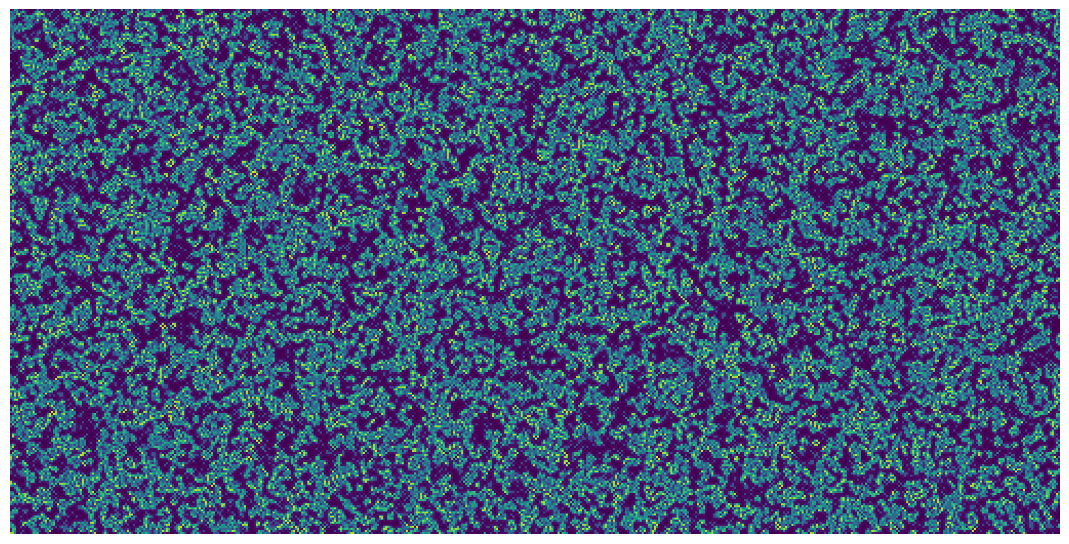

In [167]:
rng = np.random.default_rng(3)

image_shape = (256, 512)
display_shape = (512, 1024)
alive_dead_ratio = 0.25
frames_per_second = 60

rule = {"B" : [3], "S" : [2, 3]}
# rule = {"B" : [4, 6, 7, 8], "S" : [3, 5, 6, 7, 8]}
# rule = {"B" : [3, 5, 6, 7, 8], "S" : [5, 6, 7, 8]}
# rule = {"B" : [1], "S" : [0, 1, 2, 3, 4, 5, 6, 7, 8]}
# rule = {"B" : [0, 1, 3, 5, 6], "S" : [0, 1, 2, 3, 4, 5]}
# rule = {"B" : [3, 4, 5], "S" : [4, 5, 6, 7]}
# rule = {"B" : [3, 5, 6, 7, 8], "S" : [4, 6, 7, 8]}
# rule = {"B" : [3, 5], "S" : [2, 3, 4, 5, 7, 8]}
# rule = {"B" : [5, 6, 7, 8], "S" : [4, 5, 6, 7, 8]}
# rule = {"B" : [3, 5, 7, 8], "S" : [2, 4, 6, 7, 8]}
# rule = {"B" : [2], "S" : []}
# rule = {"B" : [2, 3, 4], "S" : []}
# rule = {"B" : [3, 6, 7, 8], "S" : [3, 4, 6, 7, 8]}

# Slowly building sum of automata
init_array = rng.choice([0, 1], size = image_shape, p = [1 - alive_dead_ratio, alive_dead_ratio])
array_automaton = init_array.copy()
array_automaton_sum = array_automaton.astype(float)
array_display = resize(array_automaton_sum, display_shape, order = 0)
figure, axis = plt.subplots(1, 1, figsize = (display_shape[1]/96, display_shape[0]/96), layout = "constrained")
axis.axis("off")
image = axis.imshow(array_display, vmin = 0, vmax = 1)
def animate(index):
    global array_automaton, array_automaton_sum
    array_automaton = cellular_automaton(array_automaton, rule)
    array_automaton_sum += array_automaton.astype(float)
    array_display = resize(array_automaton_sum, display_shape, order = 0)
    image.set_array(array_display)
    image.set_clim(vmin = array_display.min(), vmax = array_display.max())
    array_automaton_sum *= 0.5
    array_automaton_sum += 0.15*fftconvolve(array_automaton_sum, np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]), mode = "same")
    return [image]
animation = FuncAnimation(figure, animate, interval = 1000/frames_per_second, blit = True, cache_frame_data = False)
plt.show()

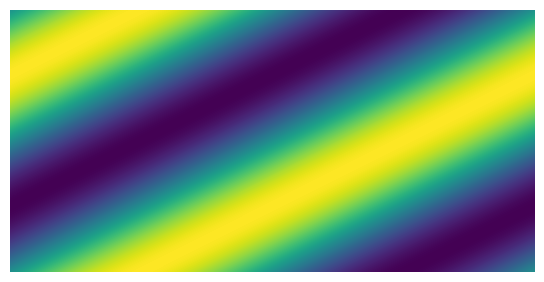

In [ ]:
rng = np.random.default_rng(3)

image_shape = (1024, 1024)
display_shape = (512, 512)
frames_per_second = 60
frames = 512

angles = np.array([np.linspace(-np.pi, np.pi, frames, endpoint = False),
                   np.linspace(0, 8*np.pi, frames, endpoint = False),
                   np.linspace(0, -4*np.pi, frames, endpoint = False)])
amplitudes = np.array([np.full(frames, 1),
                       np.full(frames, 1),
                       np.full(frames, 1)]).astype(float)
amplitudes /= amplitudes.shape[0]
frequencies = np.array([np.linspace(-1, 1, frames),
                        np.linspace(1, 3, frames),
                        np.linspace(1, 6, frames)])
phases = np.array([np.linspace(0, -16*np.pi, frames, endpoint = False),
                   np.linspace(0, -np.pi, frames, endpoint = False),
                   np.linspace(0, 2*np.pi, frames, endpoint = False)])

array_image = rotated_sin(0, 1, 2, 0, image_shape)
figure, axis = plt.subplots(1, 1, figsize = (display_shape[1]/96, display_shape[0]/96), layout = "constrained")
axis.axis("off")
image = axis.imshow(array_display, vmin = -1, vmax = 1, cmap = "viridis")
def animate(index_frame):
    array_image = np.array([rotated_sin(angles[index_layer, index_frame], amplitudes[index_layer, index_frame], frequencies[index_layer, index_frame], phases[index_layer, index_frame], image_shape) for index_layer in range(angles.shape[0])]).sum(axis = 0)
    image.set_array(array_image)
    return [image]
animation = FuncAnimation(figure, animate, frames = frames, interval = 1000/frames_per_second, blit = True, cache_frame_data = False)
plt.show()

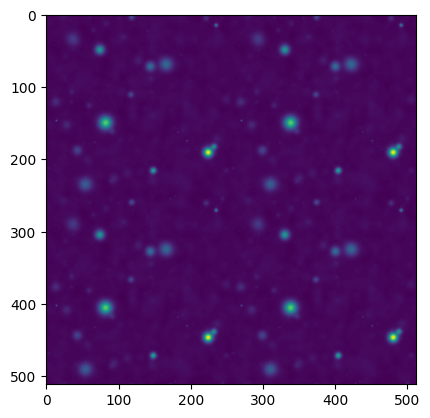

In [421]:
def weird_filter_thing(image_input):
    image_ft = np.fft.fftshift(np.fft.fft2(image_input))
    x, y = np.meshgrid(np.linspace(-1, 1, image_input.shape[1]), np.linspace(-1, 1, image_input.shape[0]))
    y_warp = rng.uniform(-1, 1, (2, image_input.shape[0], image_input.shape[1]))
    x_warp = rng.uniform(-1, 1, (2, image_input.shape[0], image_input.shape[1]))
    x *= rotated_sin(angle = rng.uniform(0, 2*np.pi), amplitude = 0.25, frequency = rng.uniform(1, 2), shape = image_input.shape, warp = y_warp)
    y *= rotated_sin(angle = rng.uniform(0, 2*np.pi), amplitude = 0.25, frequency = rng.uniform(1, 2), shape = image_input.shape, warp = x_warp)
    z = scale_array(np.linalg.norm(np.array([x, y]), axis = 0))
    image_output_ft = image_ft*z
    return scale_array(np.abs(np.fft.ifft2(np.fft.fftshift(image_output_ft))), image_input.min(), image_input.max())

image = rng.uniform(0, 1, (256, 256))
images = np.zeros((6, image.shape[0], image.shape[1]))
for index, sigma in enumerate([value**2/images.shape[0] for value in np.arange(images.shape[0]) + 1]):
    image = resize(np.tile(image, (rng.integers(1, 8), rng.integers(1, 8))), (image.shape[0], image.shape[1]))
    image /= rotated_sin(rng.uniform(0, 2*np.pi), rng.uniform(0, 0.25), rng.uniform(1, 8), rng.uniform(0, 2*np.pi), shape = image.shape, warp = np.array([image, image])) # dividing here gives a cool effect
    image = scale_array(gaussian_filter(weird_filter_thing(image), sigma, mode = "wrap"))
    images[index] = image
for _ in range(6):
    images = interpolate_images(images)
images *= np.expand_dims(np.exp(np.logspace(0, 0.5, images.shape[0])), (1, 2))
plt.figure()
plt.imshow(np.tile(images.sum(0), (2, 2)))

# plot_images = images.copy()
# factors = [value for value in np.arange(plot_images.shape[0]) + 1 if not plot_images.shape[0]%value]
# factor_y = factors[-2]
# factor_x = int(factors[-1]/factors[-2])
# size_y = 3*factor_y*image.shape[0]/max(image.shape)
# size_x = 3*factor_x*image.shape[1]/max(image.shape)
# figure, axes = plt.subplots(factor_y, factor_x, figsize = (size_x, size_y), layout = "constrained")
# for axis, image in zip(axes.flatten(), plot_images):
#     axis.imshow(image, vmin = images.min(), vmax = images.max())
#     axis.axis(False)
# plt.show()

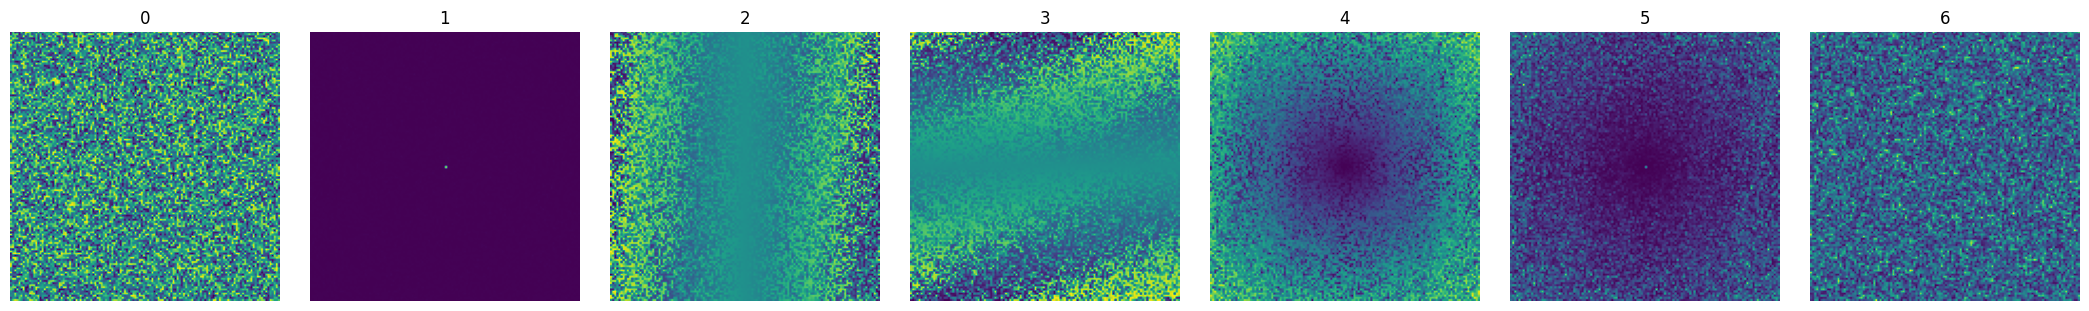

In [271]:
image = rng.uniform(0, 1, (128, 128))
image_ft = np.fft.fftshift(np.fft.fft2(image))
x, y = np.meshgrid(np.linspace(-1, 1, image.shape[1]), np.linspace(-1, 1, image.shape[0]))
warp = rng.uniform(-1, 1, (2, image.shape[0], image.shape[1]))
x *= rotated_sin(angle = rng.uniform(0, 2*np.pi), amplitude = 0.25, frequency = rng.uniform(1, 2), shape = image.shape, warp = warp)
y *= rotated_sin(angle = rng.uniform(0, 2*np.pi), amplitude = 0.25, frequency = rng.uniform(1, 2), shape = image.shape, warp = warp)
# x = gaussian_filter(x, 2)
# y = gaussian_filter(y, 2)
z = scale_array(np.linalg.norm(np.array([x, y]), axis = 0))
image_output_ft = image_ft*z
image_output = scale_array(np.abs(np.fft.ifft2(np.fft.fftshift(image_output_ft))))

plot_images = np.array([image, np.abs(image_ft), x, y, z, np.abs(image_output_ft), image_output])
factors = [value for value in np.arange(plot_images.shape[0]) + 1 if not plot_images.shape[0]%value]
factor_y = factors[-2]
factor_x = int(factors[-1]/factors[-2])
size_y = 3*factor_y*image.shape[0]/max(image.shape)
size_x = 3*factor_x*image.shape[1]/max(image.shape)
figure, axes = plt.subplots(factor_y, factor_x, figsize = (size_x, size_y), layout = "constrained")
for axis, (index, image) in zip(axes.flatten(), enumerate(plot_images)):
    axis.set_title(f"{index}")
    axis.imshow(image)
    axis.axis(False)
plt.show()

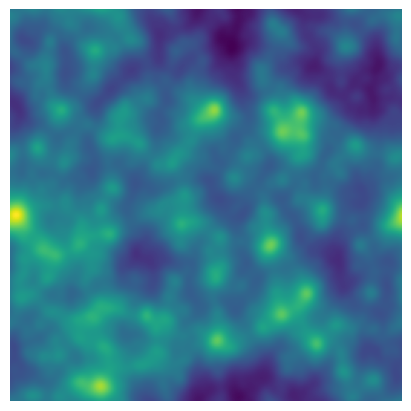

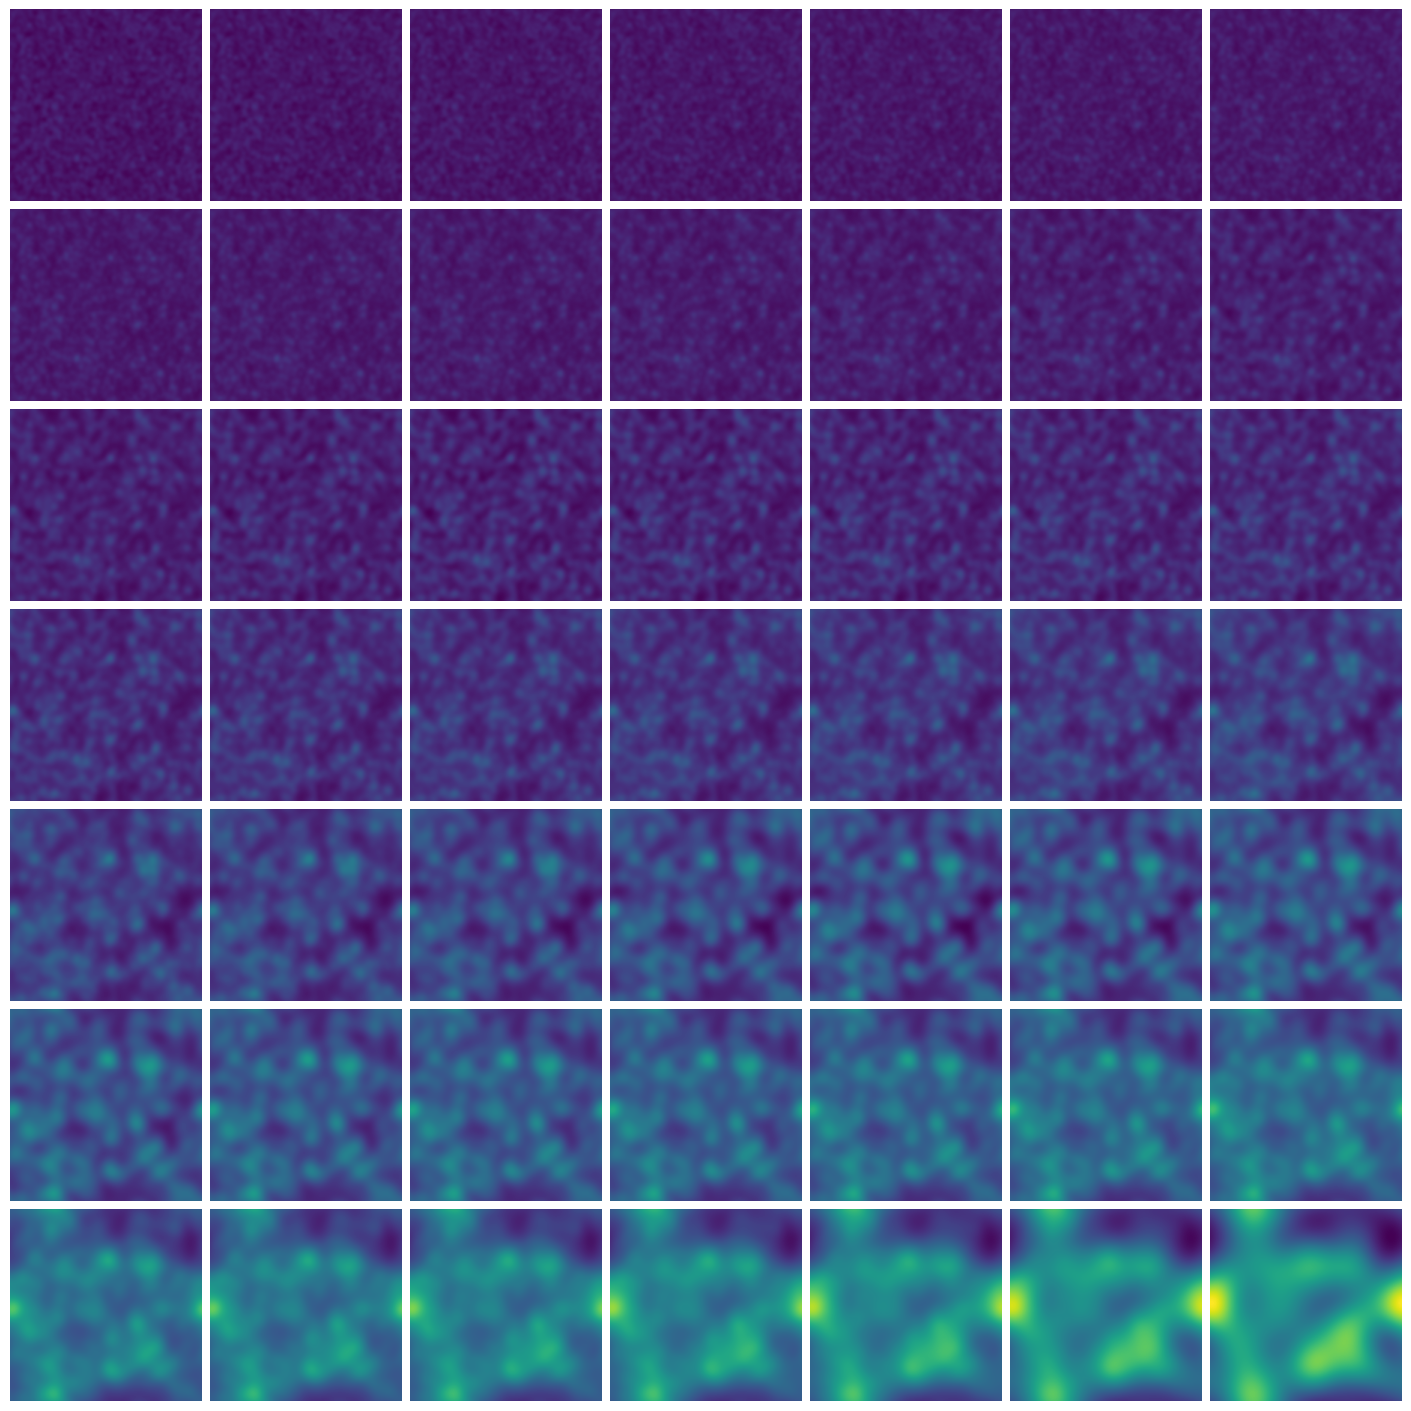

In [29]:
rng = np.random.default_rng(None)

def scaled_ft(image_input, sigma):
    noise = rng.uniform(-1, 1, image_input.shape)
    image_ft = np.fft.fftshift(np.fft.fft2(image_input))
    x, y = np.meshgrid(np.linspace(-1, 1, image_input.shape[1]), np.linspace(-1, 1, image_input.shape[0]))
    # x *= noise
    z = x**2 + y**2
    image_ft *= z
    image_output = gaussian_filter(np.abs(np.fft.ifft2(np.fft.fftshift(image_ft))), sigma, mode = "wrap")
    image_output -= image_output.min()
    image_output /= image_output.max()
    return image_output

image = rng.uniform(0, 1, (256, 256))
images = np.zeros((4, image.shape[0], image.shape[1]))
for index, sigma in enumerate(np.exp(np.logspace(0, 0.5, images.shape[0]))):
    image = scaled_ft(image, sigma)
    images[index] = image
for _ in range(4):
    images = interpolate_images(images)
images *= np.expand_dims(np.exp(np.linspace(-1, 1, images.shape[0])), (1, 2))

figure, axis = plt.subplots(1, 1, figsize = (4, 4), layout = "constrained")
axis.imshow(images.sum(0))
axis.axis(False)
factors = [value for value in np.arange(images.shape[0]) + 1 if not images.shape[0]%value]
factor_y = factors[-2]
factor_x = int(factors[-1]/factors[-2])
size_y = 2*factor_y*image.shape[0]/max(image.shape)
size_x = 2*factor_x*image.shape[1]/max(image.shape)
figure, axes = plt.subplots(factor_y, factor_x, figsize = (size_x, size_y), layout = "constrained")
for axis, image in zip(axes.flatten(), images):
    axis.imshow(image, vmin = images.min(), vmax = images.max())
    axis.axis(False)
plt.show()

In [ ]:
rng = np.random.default_rng()
display_shape = np.array([1024, 1024])
image_shape = np.array([256, 256])

display = pygame.display.set_mode(display_shape)
i = 0
running = True
while running:
    try:
        t_0 = time.time()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        angle = 2*np.pi*noise.pnoise1(i, base = 0)
        frequency = 8*(noise.pnoise1(i, base = 1) - 0.5)
        warp = np.array([rotated_sin(2*np.pi*noise.pnoise1(i, base = j), shape = image_shape) for j in np.arange(4) + 3]).sum(0)
        image = rotated_sin(angle, frequency = frequency, shape = image_shape, warp = np.array([warp, warp]))
        image = np.tile(np.expand_dims(scale_array(image, 0, 255), 2), (1, 1, 3))
        surface = pygame.surfarray.make_surface(resize(image, display_shape, order = 0).astype(np.uint8))
        display.blit(surface, (0, 0))
        pygame.display.update()
        i += 0.01
        t_1 = time.time()
        print(f"{1/(t_1 - t_0)}", end = "\r")
    except:
        running = False
        pygame.quit()
        raise
pygame.quit()

In [38]:
rng = np.random.default_rng()
display_shape = np.array([512, 1024])[::-1]
image_shape = np.array([128, 256])[::-1]

display = pygame.display.set_mode(display_shape)
i = 0
running = True
while running:
    try:
        t_0 = time.time()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        angles = 2 * np.pi * noise.pnoise1(i, base=np.arange(3))
        phases = 2 * np.pi * noise.pnoise1(i, base=np.arange(3) + 3)
        frequencies = 2 * (noise.pnoise1(i, base=np.arange(3) + 6) - 0.5)
        angles_w = 2 * np.pi * noise.pnoise1(i, base=np.arange(3) + 9, octaves=2)
        phases_w = 2 * np.pi * noise.pnoise1(i, base=np.arange(3) + 12, octaves=2)
        frequencies_w = 2 * (noise.pnoise1(i, base=np.arange(3) + 15, octaves=2) - 0.5)
        
        warp = np.sum([rotated_sin(angle, phase, frequency, shape=image_shape) 
                   for angle, phase, frequency in zip(angles_w, phases_w, frequencies_w)], axis=0)
        
        image = np.moveaxis(np.array([rotated_sin(angle, phase, frequency, shape=image_shape, warp=np.array([warp, warp])) 
                          for angle, phase, frequency in zip(angles, phases, frequencies)]), 0, -1)
        
        surface = pygame.surfarray.make_surface(scale_array(resize(image, display_shape, order=0), 0, 255).astype(np.uint8))
        display.blit(surface, (0, 0))
        pygame.display.update()
        i += 0.001
        t_1 = time.time()
        print(f"{1/(t_1 - t_0)}", end = "\r")
    except:
        running = False
        pygame.quit()
        raise
pygame.quit()

TypeError: only integer scalar arrays can be converted to a scalar index

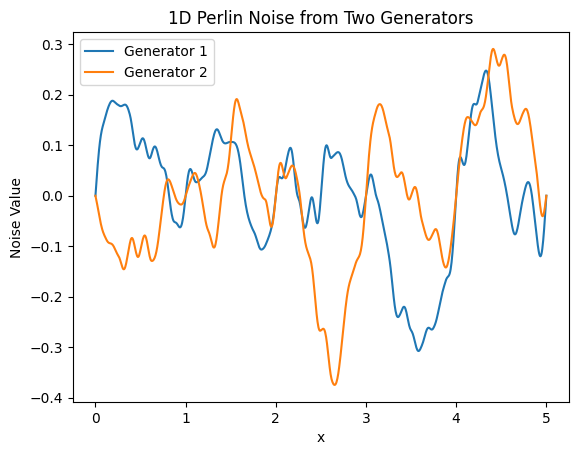

In [52]:
import noise
import numpy as np

class PerlinNoiseGenerator:
    def __init__(self, octaves=1, persistence=0.5, lacunarity=2.0, repeat=1024):
        self.octaves = octaves
        self.persistence = persistence
        self.lacunarity = lacunarity
        self.repeat = repeat
        self.base = np.random.randint(0, 10000)  # Generate a random base for each instance

    def generate_noise(self, x):
        # Add a small offset to x to avoid returning 0 for integer values
        x += rng.uniform(-1e-6, 1e-6)
        return noise.pnoise1(x, octaves=self.octaves, persistence=self.persistence, 
                             lacunarity=self.lacunarity, repeat=self.repeat, base=self.base)

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Create two instances of the PerlinNoiseGenerator
    generator1 = PerlinNoiseGenerator(octaves=4)
    generator2 = PerlinNoiseGenerator(octaves=4)

    # Generate noise for a range of x values
    x = np.linspace(0, 5, 1000)
    y1 = [generator1.generate_noise(i) for i in x]
    y2 = [generator2.generate_noise(i) for i in x]

    # Plot the noise generated by both instances
    plt.plot(x, y1, label='Generator 1')
    plt.plot(x, y2, label='Generator 2')
    plt.title('1D Perlin Noise from Two Generators')
    plt.xlabel('x')
    plt.ylabel('Noise Value')
    plt.legend()
    plt.show()

In [115]:
import numpy as np
from numba import jit

@jit(nopython=True)
def fade(t):
    return t * t * t * (t * (t * 6 - 15) + 10)

@jit(nopython=True)
def lerp(t, a, b):
    return a + t * (b - a)

@jit(nopython=True)
def grad(hash, x):
    h = hash & 15
    grad = 1 + (h & 7)  # Gradient value is one of 1, 2, ..., 8
    if h & 8:
        grad = -grad
    return grad * x

@jit(nopython=True)
def perlin(x, permutation):
    xi = int(x) & 255
    xf = x - int(x)
    u = fade(xf)

    a = permutation[xi]
    b = permutation[xi + 1]

    return lerp(u, grad(a, xf), grad(b, xf - 1))

@jit(nopython=True)
def generate_perlin_noise_1d(x, scale=100):
    permutation = np.arange(256, dtype=np.int32)
    np.random.shuffle(permutation)
    permutation = np.append(permutation, permutation)
    
    noise = np.zeros_like(x)
    for i in range(x.shape[0]):
        noise[i] = perlin(x[i] / scale, permutation)
    
    return noise

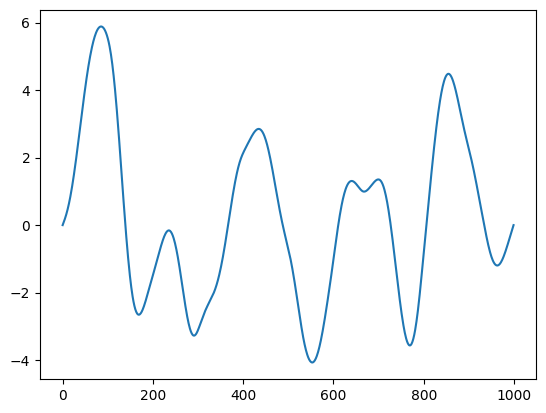

In [144]:
# Example usage
length = 1000
scale = 100
noise = np.array([generate_perlin_noise_1d(np.linspace(0, 100, 1000), n) for n in np.linspace(10, 20, 4)]).sum(axis=0)
plt.plot(noise)

In [447]:
from numba import jit

@jit(nopython=True)
def generate_coordinates(range_0, range_1):
    coordinates = np.empty((2, range_0.size, range_1.size))
    for index, value in enumerate(range_0):
        coordinates[0, index, :] = value
    for index, value in enumerate(range_1):
        coordinates[1, :, index] = value
    return coordinates

@jit(nopython=True)
def generate_rotated_coordinates(range_0, range_1, angle = 0):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    coordinates = generate_coordinates(range_0, range_1).reshape((2, range_0.size*range_1.size))
    translation = np.empty((2, 1))
    translation[0] = np.mean(coordinates[0, :])
    translation[1] = np.mean(coordinates[1, :])
    coordinates -= translation
    coordinates = rotation_matrix@coordinates
    coordinates += translation
    coordinates = np.sum(coordinates.reshape((2, range_0.size, range_1.size)), axis = 0)/2
    return coordinates

@jit(nopython=True)
def generate_rotated_sin(angle = 0, amplitude = 1, frequency = 1, phase = 0, shape = (64, 64)):
    return amplitude*np.sin(frequency*(generate_rotated_coordinates(np.linspace(0, 2*np.pi, shape[1]), np.linspace(0, 2*np.pi, shape[0]), angle) + phase))

@jit(nopython=True)
def stack_arrays(array_0, array_1, array_2):
    array_output = np.empty((array_0.shape[0], array_0.shape[1], 3))
    array_output[:, :, 0] = array_0
    array_output[:, :, 1] = array_1
    array_output[:, :, 2] = array_2
    return array_output

@jit(nopython=True)
def scale_array(array_input, minimum = 0, maximum = 1):
    array_output = array_input.copy()
    array_output -= array_output.min()
    array_output /= array_output.max()
    array_output *= maximum - minimum
    array_output += minimum
    return array_output

@jit(nopython=True)
def resize(image_input, shape_output):
    image_output = np.empty(shape_output)
    for index_0 in range(shape_output[0]):
        for index_1 in range(shape_output[1]):
            image_output[index_0, index_1] = image_input[index_0*image_input.shape[0]//shape_output[0], index_1*image_input.shape[1]//shape_output[1]]
    return image_output

In [448]:
display_shape = np.array([512, 512])[::-1]
image_shape = np.array([256, 256])[::-1]

time_steps = 512
# angle_offsets = np.array([0, 0.1, -0.1])
angle_offsets = rng.uniform(-0.2, 0.2, 3)
# amplitude_offsets = np.array([1, 2, 3])
amplitude_offsets = rng.uniform(0, 2, 3)
frequency_minimum, frequency_maximum = 2, 4
# frequency_offsets = np.array([0, 0.1, 0.2])
frequency_offsets = rng.uniform(1, 4, 3)
# phase_offsets = np.array([0, -0.1, -0.2])
phase_offsets = rng.uniform(-0.2, 0.2, 3)

angles = np.array([np.linspace(0, 2*np.pi, time_steps) + angle_offset for angle_offset in angle_offsets])
amplitudes = np.array([np.full(time_steps, amplitude_offset) for amplitude_offset in amplitude_offsets])
if frequency_minimum == frequency_maximum:
    frequencies = np.array([np.full(time_steps, frequency_minimum) + frequency_offset for frequency_offset in frequency_offsets])
else:
    frequencies = np.array([(frequency_maximum - frequency_minimum)*((np.sin(np.linspace(0, 2*np.pi, time_steps) - np.pi/2) + 1)/2) + frequency_minimum + frequency_offset for frequency_offset in frequency_offsets])
phases = np.array([np.full(time_steps, phase_offset) for phase_offset in phase_offsets])

display = pygame.display.set_mode(display_shape)
display_image = pygame.surfarray.pixels3d(display)
image = np.zeros_like(display_image).astype(float)

i = 0
running = True
while running:
    try:
        t_0 = time.time()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        for index_channel in range(3):
            image[:, :, index_channel] = resize(generate_rotated_sin(angles[index_channel, i], amplitudes[index_channel, i], frequencies[index_channel, i], phases[index_channel, i], image_shape), tuple(display_shape))
        display_image[...] = scale_array(image, 0, 255).astype(np.uint8)
        pygame.display.update()
        i += 1
        if i == time_steps:
            # angle_offsets = np.array([0, 0.1, -0.1])
            angle_offsets = rng.uniform(-0.2, 0.2, 3)
            # amplitude_offsets = np.array([1, 2, 3])
            amplitude_offsets = rng.uniform(0, 2, 3)
            frequency_minimum, frequency_maximum = 2, 4
            # frequency_offsets = np.array([0, 0.1, 0.2])
            frequency_offsets = rng.uniform(1, 4, 3)
            # phase_offsets = np.array([0, -0.1, -0.2])
            phase_offsets = rng.uniform(-0.2, 0.2, 3)

            angles = np.array([np.linspace(0, 2*np.pi, time_steps) + angle_offset for angle_offset in angle_offsets])
            amplitudes = np.array([np.full(time_steps, amplitude_offset) for amplitude_offset in amplitude_offsets])
            if frequency_minimum == frequency_maximum:
                frequencies = np.array([np.full(time_steps, frequency_minimum) + frequency_offset for frequency_offset in frequency_offsets])
            else:
                frequencies = np.array([(frequency_maximum - frequency_minimum)*((np.sin(np.linspace(0, 2*np.pi, time_steps) - np.pi/2) + 1)/2) + frequency_minimum + frequency_offset for frequency_offset in frequency_offsets])
            phases = np.array([np.full(time_steps, phase_offset) for phase_offset in phase_offsets])
        i %= time_steps
        t_1 = time.time()
        print(f"{1/(t_1 - t_0)}", end = "\r")
    except KeyboardInterrupt:
        running = False
        pygame.quit()
    except:
        running = False
        pygame.quit()
pygame.quit()